## Incremental Deep Learning for Image Classification

This notebook implements an incremental learning approach for image classification using deep learning. The idea is to train a deep learning model on a small dataset and then incrementally train the model on new data.

## Table of Contents

1. [Setup and Imports](#setup)
2. [Data Pipeline](#data-pipeline)
3. [Model Architecture](#model-architecture)
4. [Training Pipeline](#training)
5. [Evaluation](#evaluation)
6. [Results](#results)


### 1. Setup and Imports <a id='setup'></a>

Configures logging and import required libraries


In [1]:
import tensorflow as tf
import logging
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import datetime
from typing import List, Dict, Tuple, Optional
from dataclasses import dataclass
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

2024-11-07 18:00:47.231812: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-07 18:00:47.242923: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-07 18:00:47.256803: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-07 18:00:47.260822: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-07 18:00:47.271470: I tensorflow/core/platform/cpu_feature_guar

#### Configuration

In [2]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [3]:
tf.keras.mixed_precision.set_global_policy("mixed_float16")

In [4]:
tf.random.set_seed(42)
np.random.seed(42)

##### Visualization

In [5]:
sns.set_theme(style='whitegrid')

## 2. Data Pipeline <a id='data-pipeline'></a>

Configures the data split object


In [6]:
@dataclass
class DataSplit:
    train_paths: List[str]
    val_paths: List[str]
    test_paths: List[str]
    class_mapping: Dict[str, int]
    num_classes: int

### Data Manager


In [7]:
class DataManager:
    def __init__(
        self,
        base_path: str,
        img_size: Tuple[int, int] = (224, 224),
        val_split: float = 0.15,
        test_split: float = 0.15,
        random_seed: int = 42,
    ):
        self.data_dir = Path(base_path)
        self.img_size = img_size
        self.val_split = val_split
        self.test_split = test_split

        self.seed = random_seed
        self.class_counts = self._get_class_counts()
        self.sorted_classes = self._sort_classes_by_size()
        self.class_mapping = self._create_class_mapping()

    def _get_class_counts(self) -> Dict[str, int]:
        """
        Counts the number of images in each class directory.
        """

        class_counts: dict = {}
        if not self.data_dir.exists():
            raise ValueError(f"Data directory {self.data_dir} does not exist.")

        for class_dir in self.data_dir.iterdir():
            if class_dir.is_dir():
                class_counts[class_dir.name] = len(list(class_dir.glob("*.jpg")))

        return class_counts

    def _sort_classes_by_size(self) -> List[str]:
        """
        Sorts the classes by the number of images in each class.

        Returns:
          List[str]: List of class names sorted by the number of images in each class.
        """

        return sorted(
            self.class_counts.keys(),
            key=lambda x: (self.class_counts[x], int(x)),
            reverse=True,
        )

    def _create_class_mapping(self) -> Dict[str, int]:
        """
        Creates a mapping from class names to class indices.

        Returns:
          Dict[str, int]: Dictionary mapping class names to class indices.
        """

        return {
            class_name: idx
            for idx, class_name in enumerate(
                sorted(self.class_counts.keys(), key=lambda x: int(x))
            )
        }

    def get_class_subset(self, num_classes: int) -> List[str]:
        """
        Gets the top `num_classes` classes sorted by the number of images in each class.

        Args:
          num_classes (int): Number of classes to include in the dataset.

        Returns:
          List[str]: List of class names.
        """

        if num_classes > len(self.sorted_classes):
            raise ValueError(
                f"Requested {num_classes} classes, but only {len(self.sorted_classes)} available."
            )

        return self.sorted_classes[:num_classes]

    def _collect_image_paths(self, classes: List[str]) -> Tuple[List[str], List[str]]:
        """
        Collects all image paths and their corresponding labels for the
        given classes.

        Args:
          classes (List[str]): List of class names to include in the dataset.

        Returns:
          Tuple[List[str], List[str]]: Tuple containing the image paths and their corresponding labels.
        """

        image_paths, labels = [], []

        for class_name in classes:
            class_path = self.data_dir / class_name

            if not class_path.exists():
                logger.warning(f"Class directory {class_path} does not exist.")
                continue

            image_files = []
            for ext in ["*.jpg"]:
                image_files.extend(list(class_path.glob(ext)))

            if not image_files:
                logger.warning(f"No images found in {class_path}")
                continue

            image_paths.extend([str(img) for img in image_files])
            labels.extend([class_name] * len(image_files))

            logger.info(f"Collected {len(image_files)} images for class {class_name}")

            if not image_paths:
                raise ValueError(f"No images found for classes {classes}")

        return image_paths, labels

    def prepare_data_split(self, classes: List[str]) -> DataSplit:
        """
        Prepares the data split for the given classes. It first
        divides the data into train_val and test sets, and then
        further divides the train_val set into train and validation

        Args:
            classes (List[str]): List of class names to include in the dataset.

        Returns:
            DataSplit: DataSplit object containing the train, validation, and test splits.
        """

        image_paths, labels = self._collect_image_paths(classes)
        subset_mapping = {cls: self.class_mapping[cls] for cls in classes}

        train_val_paths, test_paths, train_val_labels, test_labels = train_test_split(
            image_paths,
            labels,
            test_size=self.test_split,
            stratify=labels,
            random_state=self.seed,
        )

        train_paths, val_paths, train_labels, val_labels = train_test_split(
            train_val_paths,
            train_val_labels,
            test_size=self.val_split / (1 - self.test_split),
            stratify=train_val_labels,
            random_state=self.seed,
        )

        logger.info(
            f"Split sizes - Train: {len(train_paths)}, Val: {len(val_paths)}, Test: {len(test_paths)}"
        )

        return DataSplit(
            train_paths=train_val_paths,
            val_paths=val_paths,
            test_paths=test_paths,
            class_mapping=subset_mapping,
            num_classes=len(classes),
        )

    def plot_class_distribution(self, classes: Optional[List[str]] = None):
        """
        Plots the class distribution for the given classes.

        Args:
            clases (Optional[List[str]]): List of class names to include in the plot.
        """

        if classes is None:
            classes = self.sorted_classes

        counts = [self.class_counts[cls] for cls in classes]
        plt.figure(figsize=(12, 6))
        plt.bar(classes, counts)
        plt.title("Class Distribution")
        plt.xlabel("Class")
        plt.ylabel("Number of Images")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

### Data Generator


In [8]:
import pandas as pd
import numpy as np

In [9]:
class DataGenerator:
    def __init__(self, img_size: Tuple[int, int], batch_size: int = 32):
        self.img_size = img_size
        self.batch_size = batch_size
        self.train_datagen = self._create_train_datagen()
        self.test_datagen = self._create_test_datagen()
        self.label_to_index = None
        self.num_classes = None

    def _create_train_datagen(self) -> tf.keras.preprocessing.image.ImageDataGenerator:
        """
        Creates the training data generator with data augmentation. The following augmentations are applied:
        - Rotation
        - Width and height shift
        - Shear
        - Zoom
        - Horizontal and vertical flip
        - Brightness

        Returns:
            tf.keras.preprocessing.image.ImageDataGenerator: Training data generator.
        """

        return tf.keras.preprocessing.image.ImageDataGenerator(
            rotation_range=360,
            width_shift_range=0.3,
            height_shift_range=0.3,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            vertical_flip=True,
            fill_mode="constant",
            brightness_range=(0.6, 1.4),
            channel_shift_range=0.2,
        )

    def _create_test_datagen(self) -> tf.keras.preprocessing.image.ImageDataGenerator:
        """
        Creates the test data generator with only the input preprocessing function.

        Returns:
            tf.keras.preprocessing.image.ImageDataGenerator: Test data generator
        """

        return tf.keras.preprocessing.image.ImageDataGenerator(
            preprocessing_function=self._preprocess_input,
        )

    def _preprocess_input(self, x):
        """
        Preprocesses the input image by scaling pixel values to the range of [-1, 1].

        Args:
            x (np.ndarray): Input image.

        Returns:
            np.ndarray: Preprocessed image.
        """

        x = tf.cast(x, tf.float32)

        return tf.image.per_image_standardization(x)

    def create_generators(self, data_split: DataSplit):
        """
        Creates the generators for training, validation, and testing.

        Args:
            data_split (DataSplit): DataSplit object containing the train, validation, and test splits.

        Returns:
            Tuple[tf.data.Dataset, tf.data.Dataset, tf.data.Dataset]: Tuple containing the training, validation, and test datasets.
        """

        self.label_to_index = data_split.class_mapping
        self.num_classes = data_split.num_classes

        def create_df(paths: List[str]) -> pd.DataFrame:
            return pd.DataFrame(
                {
                    "filename": paths,
                    "class": [Path(p).parent.name for p in paths],
                }
            )

        train_df = create_df(data_split.train_paths)
        val_df = create_df(data_split.val_paths)
        test_df = create_df(data_split.test_paths)

        logger.info(
            f"Training set class distribution:\n{train_df['class'].value_counts()}"
        )

        train_ds = self._create_dataset(train_df, is_training=True)
        val_ds = self._create_dataset(val_df, is_training=False)
        test_ds = self._create_dataset(test_df, is_training=False)

        return train_ds, val_ds, test_ds

    def _create_dataset(
        self, df: pd.DataFrame, is_training: bool = False
    ) -> tf.data.Dataset:
        """
        Creates the tf.data.Dataset object from the given DataFrame.

        Args:
            df (pd.DataFrame): DataFrame containing the image paths and their corresponding labels.
            is_training (bool): Whether the dataset is for training or not.

        Returns:
            tf.data.Dataset: Dataset object.
        """

        datagen = self.train_datagen if is_training else self.test_datagen
        filenames = df["filename"].values
        labels = df["class"].map(self.label_to_index).values

        dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
        dataset = dataset.map(self._parse_function, num_parallel_calls=tf.data.AUTOTUNE)

        dataset = dataset.batch(self.batch_size)

        if is_training:
            dataset = dataset.shuffle(
                buffer_size=len(df), reshuffle_each_iteration=True
            )

        dataset = dataset.prefetch(tf.data.AUTOTUNE)

        steps = len(df) // self.batch_size
        if is_training:
            self.steps_per_epoch = steps

        else:
            self.validation_steps = steps

        return dataset

    @tf.function
    def _parse_function(self, filename, label):
        """
        Loads and preprocesses the image and its corresponding label.

        Args:
            filename (tf.Tensor): Image filename.
            label (tf.Tensor): Image label.

        Returns:
            Tuple[tf.Tensor, tf.Tensor]: Tuple containing the image and its label
        """

        image = tf.io.read_file(filename)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, self.img_size)
        label = tf.one_hot(label, self.num_classes)

        return image, label

    def get_steps(self):
        return self.steps_per_epoch, self.validation_steps

    def get_num_classes(self):
        return self.num_classes

    def get_class_mapping(self):
        return self.label_to_index

## Pre-Trained Model


In [10]:
import json
from datetime import datetime

In [ ]:
class ModelManager:
    def __init__(
        self,
        img_size: Tuple[int, int] = (224, 224),
        model_dir: str = "models",
        initial_lr: float = 1e-4,
    ):
        self.img_size = img_size
        self.model_dir = Path(model_dir)
        self.model_dir.mkdir(exist_ok=True, parents=True)
        self.initial_lr = initial_lr
        self.model = None
        self.base_model = None

    def build_model(self, num_classes: int) -> tf.keras.Model:
        if self.model is None:
            self.base_model = tf.keras.applications.MobileNetV3Large(
                weights="imagenet", include_top=False, input_shape=(*self.img_size, 3)
            )

            self.base_model.trainable = False

            inputs = tf.keras.Input(shape=(*self.img_size, 3))
            x = tf.keras.applications.mobilenet_v3.preprocess_input(inputs)

            x = self.base_model(x, training=False)
            x1 = tf.keras.layers.GlobalAveragePooling2D()(x)
            x2 = tf.keras.layers.GlobalMaxPooling2D()(x)

            x = tf.keras.layers.Concatenate()([x1, x2])
            x = tf.keras.layers.Dense(512, use_bias=False)(x)
            x = tf.keras.layers.BatchNormalization()(x)
            x = tf.keras.layers.Activation("relu")(x)
            x = tf.keras.layers.Dropout(0.5)(x)

            x = tf.keras.layers.Dense(256, activation="relu")(x)
            x = tf.keras.layers.Dropout(0.3)(x)
            outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

            self.model = tf.keras.Model(inputs, outputs)

        self.current_classes = num_classes
        self._compile_model()
        return self.model

    def _compile_model(self):
        optimizer = tf.keras.optimizers.Adam(
            learning_rate=self.initial_lr, clipnorm=1.0
        )

        self.model.compile(
            optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
        )

    def train(
        self,
        train_ds,
        val_ds,
        iteration: int,
        epochs: int = 50,
        class_weights: Optional[Dict] = None,
    ) -> tf.keras.callbacks.History:
        callbacks = [
            tf.keras.callbacks.ModelCheckpoint(
                str(self.model_dir / f"best_model_iter_{iteration}.keras"),
                monitor="val_accuracy",
                mode="max",
                save_best_only=True,
                verbose=1,
            ),
            tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=10,
                restore_best_weights=True,
                verbose=1,
            ),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6, verbose=1
            ),
        ]

        history = self.model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=epochs,
            callbacks=callbacks,
            class_weight=class_weights,
        )

        return history

    def fine_tune(
        self,
        train_ds,
        val_ds,
        iteration: int,
        num_layers_to_unfreeze: int = 75,
        epochs: int = 30,
        class_weights: Optional[Dict] = None,
    ) -> tf.keras.callbacks.History:
        self.load_best_model(iteration)
        self.base_model.trainable = True

        for layer in self.base_model.layers[:-num_layers_to_unfreeze]:
            layer.trainable = False

        self.initial_lr = self.initial_lr * 0.1
        self._compile_model()

        return self.train(
            train_ds,
            val_ds,
            iteration=f"{iteration}_ft",
            epochs=epochs,
            class_weights=class_weights,
        )

    def prepare_next_iteration(
        self, previous_iteration: int, new_num_classes: int
    ) -> None:
        self.load_best_model(f"{previous_iteration}_ft")

        old_weights = [layer.get_weights() for layer in self.model.layers[:-1]]
        self.build_model(new_num_classes)

        for layer, weights in zip(self.model.layers[:-1], old_weights):
            if weights:
                layer.set_weights(weights)

    def load_best_model(self, iteration: str) -> None:
        model_path = self.model_dir / f"best_model_iter_{iteration}.keras"
        if not model_path.exists():
            raise ValueError(f"No saved model found for iteration {iteration}")

        self.model = tf.keras.models.load_model(str(model_path))
        logger.info(f"Loaded best model from iteration {iteration}")

    def save_iteration_info(self, iteration: int, metrics: Dict) -> None:
        info = {
            "iteration": iteration,
            "metrics": metrics,
            "model_config": self.model.get_config(),
            "timestamp": datetime.now().isoformat(),
        }

        with open(self.model_dir / f"iteration_{iteration}_info.json", "w") as f:
            json.dump(info, f, indent=4)

### Auxiliary function


In [12]:
def plot_history_subplot(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Training")
    plt.plot(history.history["val_accuracy"], label="Validation")
    plt.title("Model Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Training")
    plt.plot(history.history["val_loss"], label="Validation")
    plt.title("Model Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

In [13]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

In [14]:
class ModelEvaluator:
    def __init__(self, model_manager: ModelManager):
        self.model_manager = model_manager
        self.evaluation_history: Dict[int, Dict] = {}

    def evaluate_iteration(
        self,
        iteration: int,
        test_ds: tf.data.Dataset,
        class_names: List[str],
        plot: bool = True,
    ) -> Dict:
        """
        Evaluates the model for a given iteration and stores the results.
        """
        y_pred = []
        y_true = []

        for images, labels in test_ds:
            predictions = self.model_manager.model.predict(images, verbose=0)
            y_pred.extend(np.argmax(predictions, axis=1))
            y_true.extend(np.argmax(labels, axis=1))

        unique_labels = np.unique(y_true)
        actual_class_names = [class_names[i] for i in unique_labels]

        cm = confusion_matrix(y_true, y_pred)
        report = classification_report(
            y_true, y_pred, target_names=actual_class_names, output_dict=True
        )

        results = {
            "confusion_matrix": cm,
            "classification_report": report,
            "class_names": actual_class_names,
        }
        self.evaluation_history[iteration] = results

        if plot:
            self.plot_confusion_matrix(iteration)

        return results

    def plot_confusion_matrix(
        self, iteration: int, figsize: Tuple[int, int] = (20, 8), cmap: str = "Blues"
    ) -> None:
        """
        Plots normalized and raw confusion matrices side by side.
        """
        if iteration not in self.evaluation_history:
            raise ValueError(f"No evaluation data found for iteration {iteration}")

        results = self.evaluation_history[iteration]
        cm = results["confusion_matrix"]
        class_names = results["class_names"]

        # Create figure with two subplots side by side
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

        # Plot normalized confusion matrix
        cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
        sns.heatmap(
            cm_normalized,
            annot=True,
            fmt=".2f",
            cmap=cmap,
            xticklabels=class_names,
            yticklabels=class_names,
            ax=ax1,
        )
        ax1.set_title(f"Normalized Confusion Matrix - Iteration {iteration}")
        ax1.set_ylabel("True Label")
        ax1.set_xlabel("Predicted Label")
        plt.setp(ax1.get_xticklabels(), rotation=45, ha="right")

        # Plot raw counts confusion matrix
        sns.heatmap(
            cm,
            annot=True,
            fmt="d",
            cmap=cmap,
            xticklabels=class_names,
            yticklabels=class_names,
            ax=ax2,
        )
        ax2.set_title(f"Raw Counts Confusion Matrix - Iteration {iteration}")
        ax2.set_ylabel("True Label")
        ax2.set_xlabel("Predicted Label")
        plt.setp(ax2.get_xticklabels(), rotation=45, ha="right")

        plt.tight_layout()
        plt.show()

    def print_classification_report(self, iteration: int) -> None:
        """Prints the classification report for a given iteration."""
        if iteration not in self.evaluation_history:
            raise ValueError(f"No evaluation data found for iteration {iteration}")

        report = self.evaluation_history[iteration]["classification_report"]
        print(f"\nClassification Report - Iteration {iteration}")
        print("-" * 60)

        for class_name in report.keys():
            if class_name in ["accuracy", "macro avg", "weighted avg"]:
                continue
            metrics = report[class_name]
            print(
                f"{class_name::<15} Precision: {metrics['precision']:.3f}  "
                f"Recall: {metrics['recall']:.3f}  "
                f"F1-score: {metrics['f1-score']:.3f}"
            )

        print("-" * 60)
        print(f"Accuracy: {report['accuracy']:.3f}")

In [15]:
def compare_iterations_performance(evaluator, iterations=[1, 2]):
    plt.figure(figsize=(15, 6))

    for iteration in iterations:
        if iteration in evaluator.evaluation_history:
            report = evaluator.evaluation_history[iteration]["classification_report"]
            classes = evaluator.evaluation_history[iteration]["class_names"]

            # Get F1 scores for each class
            f1_scores = [report[cls]["f1-score"] for cls in classes]

            plt.subplot(1, 2, 1)
            plt.plot(
                range(len(classes)),
                f1_scores,
                marker="o",
                label=f"Iteration {iteration}",
            )
            plt.xticks(range(len(classes)), classes, rotation=45)
            plt.ylabel("F1 Score")
            plt.title("F1 Score by Class")
            plt.legend()

            # Get accuracies
            accuracies = [report[cls]["precision"] for cls in classes]

            plt.subplot(1, 2, 2)
            plt.plot(
                range(len(classes)),
                accuracies,
                marker="o",
                label=f"Iteration {iteration}",
            )
            plt.xticks(range(len(classes)), classes, rotation=45)
            plt.ylabel("Precision")
            plt.title("Precision by Class")
            plt.legend()

    plt.tight_layout()
    plt.show()

## Main Execution


In [16]:
dataset_manager = DataManager(base_path="../../data/day", img_size=(224, 224))
data_generator = DataGenerator(img_size=(224, 224), batch_size=32)
model_manager = ModelManager(img_size=(224, 224), model_dir="saved_models")
evaluator = ModelEvaluator(model_manager)

## First Execution


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


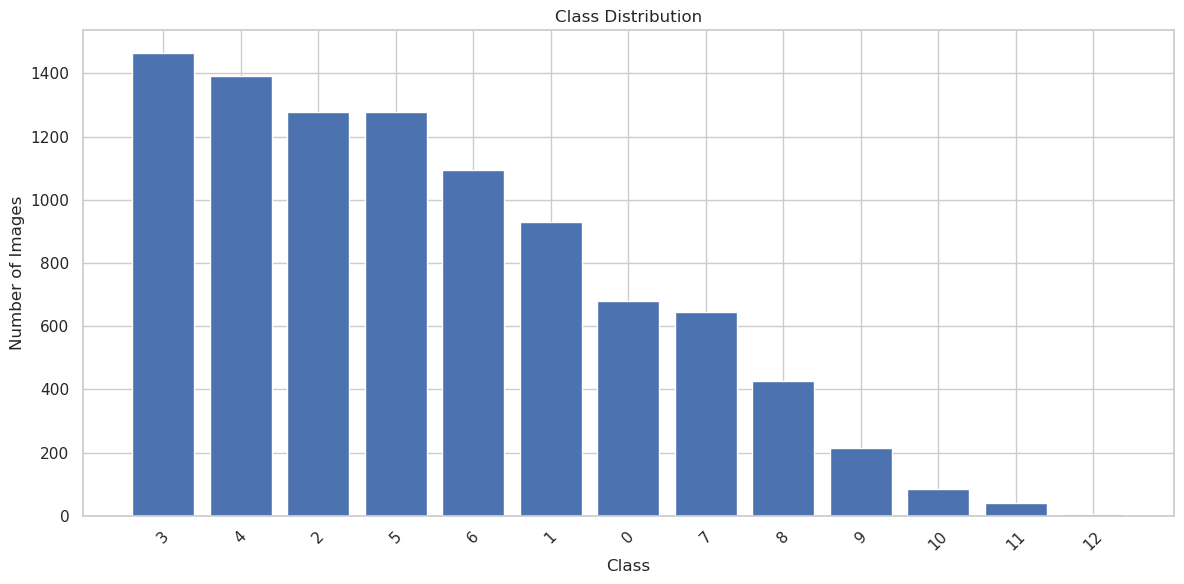

In [17]:
dataset_manager.plot_class_distribution()

### First Execution: Top 5 classes with highest probabilities


In [18]:
initial_classes = dataset_manager.get_class_subset(num_classes=8)
data_split = dataset_manager.prepare_data_split(initial_classes)

INFO:__main__:Collected 1463 images for class 3
INFO:__main__:Collected 1391 images for class 4
INFO:__main__:Collected 1279 images for class 2
INFO:__main__:Collected 1278 images for class 5
INFO:__main__:Collected 1094 images for class 6
INFO:__main__:Collected 929 images for class 1
INFO:__main__:Collected 680 images for class 0
INFO:__main__:Collected 645 images for class 7
INFO:__main__:Split sizes - Train: 6131, Val: 1314, Test: 1314


In [19]:
train_gen, val_gen, test_gen = data_generator.create_generators(data_split)

INFO:__main__:Training set class distribution:
class
3    1244
4    1182
2    1087
5    1086
6     930
1     790
0     578
7     548
Name: count, dtype: int64
I0000 00:00:1731024050.615372  271324 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1731024054.354031  271324 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1731024054.354092  271324 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1731024054.366831  271324 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1731024054.366908  271324 cuda_execut

#### Calculating Class Weights


In [20]:
total_samples = sum(dataset_manager.class_counts[cls] for cls in initial_classes)

class_weights = {
    data_split.class_mapping[cls]: total_samples
    / (len(initial_classes) * dataset_manager.class_counts[cls])
    for cls in initial_classes
}

In [21]:
steps_per_epoch, validation_steps = data_generator.get_steps()
logger.info(f"Steps per epoch: {steps_per_epoch}, Validation steps: {validation_steps}")

INFO:__main__:Steps per epoch: 232, Validation steps: 41


#### Initial Model


In [22]:
model = model_manager.build_model(data_generator.get_num_classes())
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ MobileNetV3Large    │ (None, 7, 7, 960) │  2,996,352 │ input_layer_1[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 960)       │          0 │ MobileNetV3Large… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 960)       │          0 │ MobileNetV3Large… │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 1920)      │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │    983,040 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 512)       │      2,048 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_20       │ (None, 512)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512)       │          0 │ activation_20[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │    131,328 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 8)         │      2,056 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,114,824 (15.70 MB)

 Trainable params: 1,117,448 (4.26 MB)

 Non-trainable params: 2,997,376 (11.43 MB)

In [23]:
history = model_manager.train(
    train_gen,
    val_gen,
    iteration=1,
    epochs=100,
    class_weights=class_weights,
)

Epoch 1/100


I0000 00:00:1731024072.775132  271403 service.cc:146] XLA service 0x7fe634011ef0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731024072.775189  271403 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-11-07 18:01:12.939581: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-07 18:01:13.839242: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90300
E0000 00:00:1731024080.035605  271403 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1731024080.272368  271403 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsig

  7/233 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.1409 - loss: 2.6935   

I0000 00:00:1731024083.891694  271403 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


165/233 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3063 - loss: 1.8118

E0000 00:00:1731024095.305695  271402 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1731024095.550872  271402 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1731024095.795027  271402 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


230/233 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.3254 - loss: 1.7177

2024-11-07 18:01:42.911331: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1779', 12 bytes spill stores, 12 bytes spill loads

2024-11-07 18:01:47.560637: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1779', 8 bytes spill stores, 8 bytes spill loads

E0000 00:00:1731024111.626350  271401 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1731024111.869291  271401 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1731024112.129923  271401 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a


Epoch 1: val_accuracy improved from -inf to 0.46575, saving model to saved_models/best_model_iter_1.keras
233/233 ━━━━━━━━━━━━━━━━━━━━ 59s 140ms/step - accuracy: 0.3263 - loss: 1.7131 - val_accuracy: 0.4658 - val_loss: 1.2426 - learning_rate: 0.0010
Epoch 2/100


2024-11-07 18:02:06.466422: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 218 of 7445


 11/233 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.5417 - loss: 1.0503

2024-11-07 18:02:06.907382: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4822 - loss: 1.1212
Epoch 2: val_accuracy improved from 0.46575 to 0.54871, saving model to saved_models/best_model_iter_1.keras
233/233 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - accuracy: 0.4822 - loss: 1.1212 - val_accuracy: 0.5487 - val_loss: 1.0282 - learning_rate: 0.0010
Epoch 3/100
230/233 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5272 - loss: 1.0258
Epoch 3: val_accuracy improved from 0.54871 to 0.59589, saving model to saved_models/best_model_iter_1.keras
233/233 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - accuracy: 0.5271 - loss: 1.0260 - val_accuracy: 0.5959 - val_loss: 0.9233 - learning_rate: 0.0010
Epoch 4/100
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5884 - loss: 0.9268
Epoch 4: val_accuracy did not improve from 0.59589
233/233 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.5883 - loss: 0.9270 - val_accuracy: 0.5434 - val_loss: 1.0609 - learning_rate: 0.0010
Epoch 5/100


2024-11-07 18:02:47.775038: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 224 of 7445


 10/233 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.5349 - loss: 0.9839

2024-11-07 18:02:48.052869: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5992 - loss: 0.8840
Epoch 5: val_accuracy improved from 0.59589 to 0.66210, saving model to saved_models/best_model_iter_1.keras
233/233 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - accuracy: 0.5992 - loss: 0.8841 - val_accuracy: 0.6621 - val_loss: 0.8004 - learning_rate: 0.0010
Epoch 6/100
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6132 - loss: 0.8315
Epoch 6: val_accuracy did not improve from 0.66210
233/233 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.6131 - loss: 0.8316 - val_accuracy: 0.6400 - val_loss: 0.8391 - learning_rate: 0.0010
Epoch 7/100
232/233 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6486 - loss: 0.7966
Epoch 7: val_accuracy improved from 0.66210 to 0.71766, saving model to saved_models/best_model_iter_1.keras
233/233 ━━━━━━━━━━━━━━━━━━━━ 15s 36ms/step - accuracy: 0.6485 - loss: 0.7967 - val_accuracy: 0.7177 - val_loss: 0.6878 - learning_rate: 0.0010
Epoch 8/100
230/233 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/s

2024-11-07 18:05:05.698559: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 232 of 7445
2024-11-07 18:05:05.713271: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


230/233 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7828 - loss: 0.5017
Epoch 16: val_accuracy improved from 0.77093 to 0.78463, saving model to saved_models/best_model_iter_1.keras
233/233 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step - accuracy: 0.7827 - loss: 0.5021 - val_accuracy: 0.7846 - val_loss: 0.4827 - learning_rate: 0.0010
Epoch 17/100
230/233 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7973 - loss: 0.4849
Epoch 17: val_accuracy improved from 0.78463 to 0.79148, saving model to saved_models/best_model_iter_1.keras
233/233 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.7971 - loss: 0.4851 - val_accuracy: 0.7915 - val_loss: 0.5092 - learning_rate: 0.0010
Epoch 18/100
232/233 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8107 - loss: 0.4510
Epoch 18: val_accuracy did not improve from 0.79148
233/233 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.8106 - loss: 0.4512 - val_accuracy: 0.7907 - val_loss: 0.4701 - learning_rate: 0.0010
Epoch 19/100
  1/233 ━━━━━━━━━━━━━━━━━━━━ 39:

2024-11-07 18:05:43.031689: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 232 of 7445
2024-11-07 18:05:43.046869: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


230/233 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8097 - loss: 0.4460
Epoch 19: val_accuracy did not improve from 0.79148
233/233 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step - accuracy: 0.8095 - loss: 0.4465 - val_accuracy: 0.7709 - val_loss: 0.5424 - learning_rate: 0.0010
Epoch 20/100
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8254 - loss: 0.4143
Epoch 20: val_accuracy did not improve from 0.79148
233/233 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.8253 - loss: 0.4145 - val_accuracy: 0.7892 - val_loss: 0.4696 - learning_rate: 0.0010
Epoch 21/100
231/233 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8258 - loss: 0.4170
Epoch 21: val_accuracy improved from 0.79148 to 0.81431, saving model to saved_models/best_model_iter_1.keras
233/233 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.8256 - loss: 0.4173 - val_accuracy: 0.8143 - val_loss: 0.4122 - learning_rate: 0.0010
Epoch 22/100
231/233 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8327 - loss: 0.3958
Epoch 22: val_

2024-11-07 18:06:56.862256: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 233 of 7445
2024-11-07 18:06:56.862396: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


232/233 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8539 - loss: 0.3477
Epoch 25: val_accuracy did not improve from 0.81887
233/233 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.8537 - loss: 0.3480 - val_accuracy: 0.8075 - val_loss: 0.4240 - learning_rate: 0.0010
Epoch 26/100
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8575 - loss: 0.3396
Epoch 26: val_accuracy did not improve from 0.81887
233/233 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.8574 - loss: 0.3398 - val_accuracy: 0.8052 - val_loss: 0.4027 - learning_rate: 0.0010
Epoch 27/100
231/233 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8496 - loss: 0.3459
Epoch 27: val_accuracy did not improve from 0.81887
233/233 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.8495 - loss: 0.3463 - val_accuracy: 0.8082 - val_loss: 0.3923 - learning_rate: 0.0010
Epoch 28/100
230/233 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8627 - loss: 0.3280
Epoch 28: val_accuracy did not improve from 0.81887
233/233 ━━━━━━━━━━━━

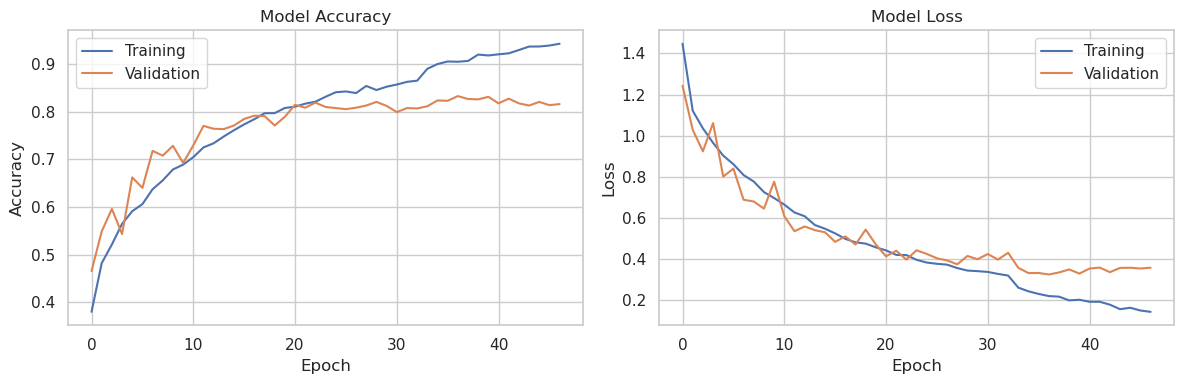

In [24]:
plot_history_subplot(history)

In [25]:
history_finetune = model_manager.fine_tune(
    train_gen,
    val_gen,
    iteration=1,
    num_layers_to_unfreeze=50,
    epochs=30,
    class_weights=class_weights,
)

INFO:__main__:Loaded best model from iteration 1


Epoch 1/30
230/233 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9226 - loss: 0.1954
Epoch 1: val_accuracy improved from -inf to 0.82572, saving model to saved_models/best_model_iter_1_ft.keras
233/233 ━━━━━━━━━━━━━━━━━━━━ 29s 53ms/step - accuracy: 0.9225 - loss: 0.1953 - val_accuracy: 0.8257 - val_loss: 0.3214 - learning_rate: 1.0000e-04
Epoch 2/30
230/233 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9242 - loss: 0.1862
Epoch 2: val_accuracy improved from 0.82572 to 0.82648, saving model to saved_models/best_model_iter_1_ft.keras
233/233 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.9242 - loss: 0.1862 - val_accuracy: 0.8265 - val_loss: 0.3199 - learning_rate: 1.0000e-04
Epoch 3/30
230/233 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9328 - loss: 0.1691
Epoch 3: val_accuracy did not improve from 0.82648
233/233 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.9328 - loss: 0.1691 - val_accuracy: 0.8219 - val_loss: 0.3179 - learning_rate: 1.0000e-04
Epoch 4/30
232/233 ━━━━━━━

2024-11-07 18:13:30.914294: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 220 of 7445


  1/233 ━━━━━━━━━━━━━━━━━━━━ 40:50 11s/step - accuracy: 0.9375 - loss: 0.1853

2024-11-07 18:13:31.325169: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


230/233 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9387 - loss: 0.1420
Epoch 9: val_accuracy did not improve from 0.83181
233/233 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step - accuracy: 0.9387 - loss: 0.1420 - val_accuracy: 0.8242 - val_loss: 0.3202 - learning_rate: 1.0000e-04
Epoch 10/30
231/233 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9372 - loss: 0.1430
Epoch 10: val_accuracy did not improve from 0.83181
233/233 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.9372 - loss: 0.1431 - val_accuracy: 0.8204 - val_loss: 0.3173 - learning_rate: 1.0000e-04
Epoch 11/30
232/233 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9402 - loss: 0.1453
Epoch 11: val_accuracy did not improve from 0.83181
233/233 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.9402 - loss: 0.1453 - val_accuracy: 0.8242 - val_loss: 0.3187 - learning_rate: 1.0000e-04
Epoch 12/30
232/233 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9358 - loss: 0.1457
Epoch 12: val_accuracy did not improve from 0.83181

Epoch 12: R

2024-11-07 18:14:43.867605: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 230 of 7445
2024-11-07 18:14:43.946214: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9411 - loss: 0.1348
Epoch 15: val_accuracy did not improve from 0.83181
233/233 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - accuracy: 0.9411 - loss: 0.1348 - val_accuracy: 0.8272 - val_loss: 0.3197 - learning_rate: 5.0000e-05
Epoch 16/30
230/233 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9459 - loss: 0.1414
Epoch 16: val_accuracy did not improve from 0.83181
233/233 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.9459 - loss: 0.1413 - val_accuracy: 0.8250 - val_loss: 0.3161 - learning_rate: 5.0000e-05
Epoch 17/30
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9419 - loss: 0.1441
Epoch 17: val_accuracy did not improve from 0.83181

Epoch 17: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
233/233 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.9419 - loss: 0.1441 - val_accuracy: 0.8204 - val_loss: 0.3158 - learning_rate: 5.0000e-05
Epoch 18/30
  1/233 ━━━━━━━━━━━━━━━━━━━━ 39:34 10s/step - accuracy: 0.968

2024-11-07 18:15:20.545958: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 230 of 7445
2024-11-07 18:15:20.620724: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


231/233 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9541 - loss: 0.1239
Epoch 18: val_accuracy did not improve from 0.83181
233/233 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.9541 - loss: 0.1239 - val_accuracy: 0.8212 - val_loss: 0.3171 - learning_rate: 2.5000e-05
Epoch 18: early stopping
Restoring model weights from the end of the best epoch: 8.


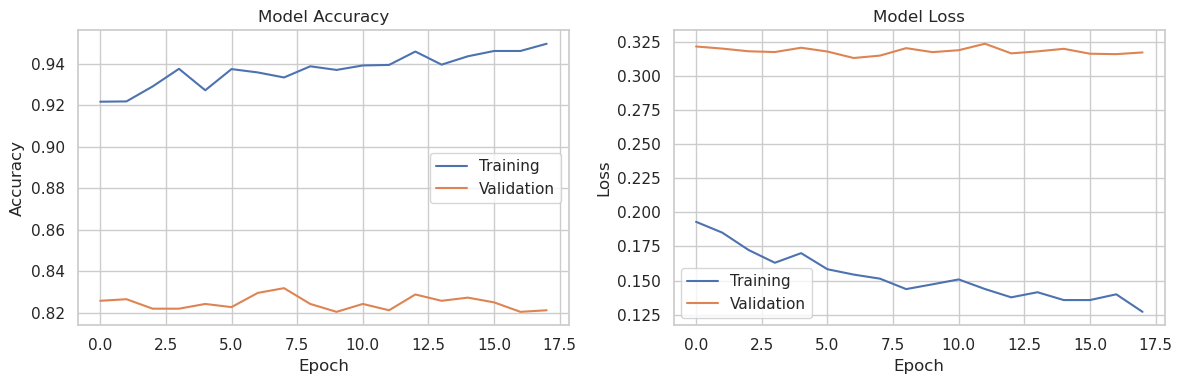

In [26]:
plot_history_subplot(history_finetune)

2024-11-07 18:15:26.313371: E tensorflow/core/util/util.cc:131] oneDNN supports DT_HALF only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.
2024-11-07 18:15:33.969550: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


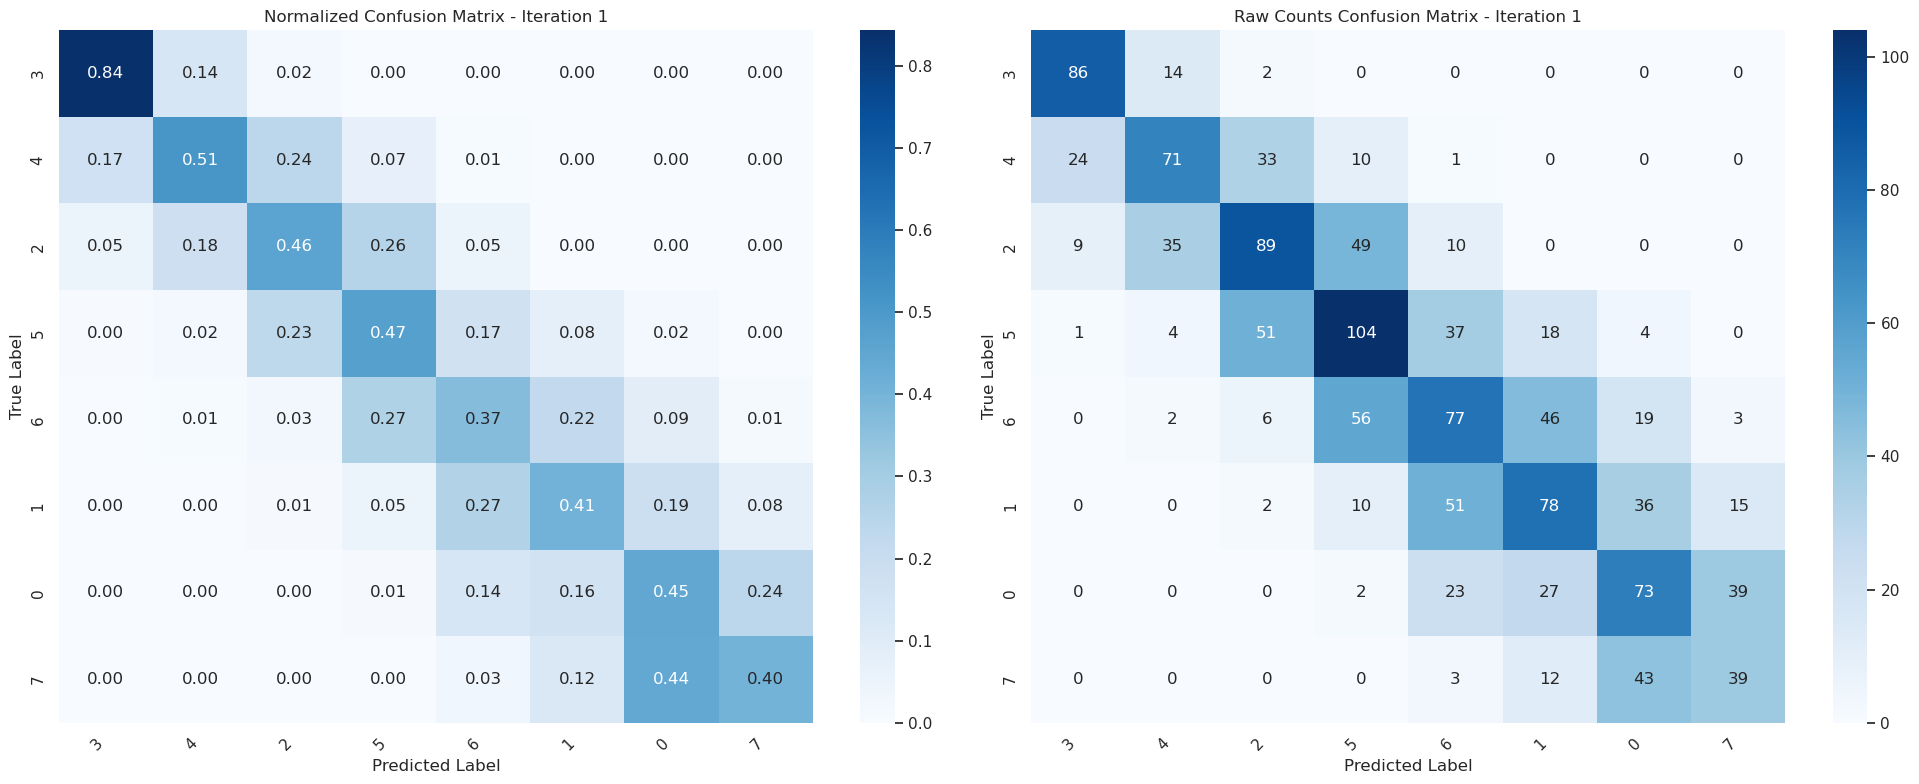

In [27]:
evaluation_results = evaluator.evaluate_iteration(
    iteration=1, test_ds=test_gen, class_names=initial_classes
)

In [28]:
evaluator.print_classification_report(iteration=1)


Classification Report - Iteration 1
------------------------------------------------------------
3:::::::::::::: Precision: 0.717  Recall: 0.843  F1-score: 0.775
4:::::::::::::: Precision: 0.563  Recall: 0.511  F1-score: 0.536
2:::::::::::::: Precision: 0.486  Recall: 0.464  F1-score: 0.475
5:::::::::::::: Precision: 0.450  Recall: 0.475  F1-score: 0.462
6:::::::::::::: Precision: 0.381  Recall: 0.368  F1-score: 0.375
1:::::::::::::: Precision: 0.431  Recall: 0.406  F1-score: 0.418
0:::::::::::::: Precision: 0.417  Recall: 0.445  F1-score: 0.431
7:::::::::::::: Precision: 0.406  Recall: 0.402  F1-score: 0.404
------------------------------------------------------------
Accuracy: 0.470


#### Second Iteration: The next classes with highest probabilities


In [43]:
all_classes = dataset_manager.get_class_subset(num_classes=9)
new_classes = all_classes[8:]

print(f"Original classes: {all_classes[:8]}")
print(f"New classes: {new_classes}")
print(f"All classes: {all_classes}")

Original classes: ['3', '4', '2', '5', '6', '1', '0', '7']
New classes: ['8']
All classes: ['3', '4', '2', '5', '6', '1', '0', '7', '8']


In [30]:
data_split = dataset_manager.prepare_data_split(all_classes)

INFO:__main__:Collected 1463 images for class 3
INFO:__main__:Collected 1391 images for class 4
INFO:__main__:Collected 1279 images for class 2
INFO:__main__:Collected 1278 images for class 5
INFO:__main__:Collected 1094 images for class 6
INFO:__main__:Collected 929 images for class 1
INFO:__main__:Collected 680 images for class 0
INFO:__main__:Collected 645 images for class 7
INFO:__main__:Collected 426 images for class 8
INFO:__main__:Split sizes - Train: 6429, Val: 1378, Test: 1378


In [31]:
train_gen, val_gen, test_gen = data_generator.create_generators(data_split)

INFO:__main__:Training set class distribution:
class
3    1244
4    1182
2    1087
5    1086
6     930
1     790
0     578
7     548
8     362
Name: count, dtype: int64


In [32]:
total_samples = sum(dataset_manager.class_counts[cls] for cls in all_classes)
class_weights = {
    data_split.class_mapping[cls]: total_samples
    / (len(all_classes) * dataset_manager.class_counts[cls])
    for cls in all_classes
}

In [33]:
evaluator = ModelEvaluator(model_manager)

In [34]:
model_manager.prepare_next_iteration(
    previous_iteration=1,
    new_num_classes=len(all_classes),
)

INFO:__main__:Loaded best model from iteration 1_ft


In [35]:
history = model_manager.train(
    train_gen,
    val_gen,
    iteration=2,
    epochs=100,
    class_weights=class_weights,
)

Epoch 1/100
218/244 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7700 - loss: 0.5020

E0000 00:00:1731024962.482402  271400 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1731024962.736380  271400 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1731024962.962536  271400 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2024-11-07 18:16:03.134533: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng3{k11=0} for conv (f16[31,7,7,960]{3,2,1,0}, u8[0]{0}) custom-call(f16[31,7,7,960]{3,2,1,0}, f16[960,5,5,1]{3,2,1,0}), window={size=5x5 pad=2_2x2_2}, dim_labels=b01f_o01i->b01f, feature_group_count=960, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on

242/244 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.7699 - loss: 0.5016
Epoch 1: val_accuracy improved from -inf to 0.77504, saving model to saved_models/best_model_iter_2.keras
244/244 ━━━━━━━━━━━━━━━━━━━━ 38s 84ms/step - accuracy: 0.7699 - loss: 0.5015 - val_accuracy: 0.7750 - val_loss: 0.3303 - learning_rate: 1.0000e-04
Epoch 2/100
241/244 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7694 - loss: 0.4465
Epoch 2: val_accuracy improved from 0.77504 to 0.77576, saving model to saved_models/best_model_iter_2.keras
244/244 ━━━━━━━━━━━━━━━━━━━━ 15s 35ms/step - accuracy: 0.7693 - loss: 0.4467 - val_accuracy: 0.7758 - val_loss: 0.3195 - learning_rate: 1.0000e-04
Epoch 3/100
241/244 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7789 - loss: 0.4034
Epoch 3: val_accuracy improved from 0.77576 to 0.78012, saving model to saved_models/best_model_iter_2.keras
244/244 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.7788 - loss: 0.4036 - val_accuracy: 0.7801 - val_loss: 0.3048 - learning_

2024-11-07 18:17:01.762307: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:572: Filling up shuffle buffer (this may take a while): 239 of 7807
2024-11-07 18:17:01.905821: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7932 - loss: 0.3720
Epoch 5: val_accuracy did not improve from 0.78012
244/244 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - accuracy: 0.7932 - loss: 0.3720 - val_accuracy: 0.7779 - val_loss: 0.3026 - learning_rate: 1.0000e-04
Epoch 6/100
242/244 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7937 - loss: 0.3398
Epoch 6: val_accuracy did not improve from 0.78012
244/244 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.7936 - loss: 0.3400 - val_accuracy: 0.7765 - val_loss: 0.3018 - learning_rate: 1.0000e-04
Epoch 7/100
242/244 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7922 - loss: 0.3374
Epoch 7: val_accuracy did not improve from 0.78012
244/244 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.7922 - loss: 0.3375 - val_accuracy: 0.7801 - val_loss: 0.2966 - learning_rate: 1.0000e-04
Epoch 8/100


2024-11-07 18:17:38.670283: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:572: Filling up shuffle buffer (this may take a while): 236 of 7807


  1/244 ━━━━━━━━━━━━━━━━━━━━ 41:53 10s/step - accuracy: 0.7188 - loss: 0.4251

2024-11-07 18:17:38.873943: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


243/244 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7789 - loss: 0.3542
Epoch 8: val_accuracy improved from 0.78012 to 0.78520, saving model to saved_models/best_model_iter_2.keras
244/244 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - accuracy: 0.7790 - loss: 0.3541 - val_accuracy: 0.7852 - val_loss: 0.2928 - learning_rate: 1.0000e-04
Epoch 9/100
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7988 - loss: 0.3180
Epoch 9: val_accuracy improved from 0.78520 to 0.78737, saving model to saved_models/best_model_iter_2.keras
244/244 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.7988 - loss: 0.3180 - val_accuracy: 0.7874 - val_loss: 0.2935 - learning_rate: 1.0000e-04
Epoch 10/100
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8005 - loss: 0.3249
Epoch 10: val_accuracy improved from 0.78737 to 0.79028, saving model to saved_models/best_model_iter_2.keras
244/244 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - accuracy: 0.8005 - loss: 0.3249 - val_accuracy: 0.7903 - val_loss: 0.2918 - lear

2024-11-07 18:18:19.052663: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:572: Filling up shuffle buffer (this may take a while): 215 of 7807


 13/244 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8580 - loss: 0.2357

2024-11-07 18:18:19.950510: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


243/244 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8138 - loss: 0.2921
Epoch 11: val_accuracy improved from 0.79028 to 0.79100, saving model to saved_models/best_model_iter_2.keras
244/244 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - accuracy: 0.8137 - loss: 0.2923 - val_accuracy: 0.7910 - val_loss: 0.2921 - learning_rate: 1.0000e-04
Epoch 12/100
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8167 - loss: 0.2902
Epoch 12: val_accuracy improved from 0.79100 to 0.79173, saving model to saved_models/best_model_iter_2.keras
244/244 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.8167 - loss: 0.2902 - val_accuracy: 0.7917 - val_loss: 0.2925 - learning_rate: 1.0000e-04
Epoch 13/100
243/244 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8110 - loss: 0.3044
Epoch 13: val_accuracy did not improve from 0.79173
244/244 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step - accuracy: 0.8109 - loss: 0.3045 - val_accuracy: 0.7859 - val_loss: 0.2885 - learning_rate: 1.0000e-04
Epoch 14/100
242/244 ━━━━━━━━━━━━

2024-11-07 18:19:26.700312: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:572: Filling up shuffle buffer (this may take a while): 221 of 7807


  1/244 ━━━━━━━━━━━━━━━━━━━━ 43:44 11s/step - accuracy: 0.7500 - loss: 0.3170

2024-11-07 18:19:27.361752: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


242/244 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8156 - loss: 0.2863
Epoch 16: val_accuracy did not improve from 0.79173
244/244 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - accuracy: 0.8156 - loss: 0.2863 - val_accuracy: 0.7823 - val_loss: 0.2854 - learning_rate: 1.0000e-04
Epoch 17/100
241/244 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8109 - loss: 0.2816
Epoch 17: val_accuracy did not improve from 0.79173
244/244 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.8109 - loss: 0.2816 - val_accuracy: 0.7823 - val_loss: 0.2858 - learning_rate: 1.0000e-04
Epoch 18/100
243/244 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8181 - loss: 0.2755
Epoch 18: val_accuracy improved from 0.79173 to 0.79608, saving model to saved_models/best_model_iter_2.keras
244/244 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.8181 - loss: 0.2756 - val_accuracy: 0.7961 - val_loss: 0.2883 - learning_rate: 1.0000e-04
Epoch 19/100


2024-11-07 18:20:06.484692: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:572: Filling up shuffle buffer (this may take a while): 232 of 7807


  2/244 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - accuracy: 0.9453 - loss: 0.1514 

2024-11-07 18:20:06.805958: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


243/244 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8276 - loss: 0.2708
Epoch 19: val_accuracy did not improve from 0.79608
244/244 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step - accuracy: 0.8275 - loss: 0.2708 - val_accuracy: 0.7837 - val_loss: 0.2828 - learning_rate: 1.0000e-04
Epoch 20/100
243/244 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8261 - loss: 0.2646
Epoch 20: val_accuracy did not improve from 0.79608
244/244 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.8260 - loss: 0.2647 - val_accuracy: 0.7874 - val_loss: 0.2849 - learning_rate: 1.0000e-04
Epoch 21/100
242/244 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8286 - loss: 0.2509
Epoch 21: val_accuracy did not improve from 0.79608
244/244 ━━━━━━━━━━━━━━━━━━━━ 15s 35ms/step - accuracy: 0.8286 - loss: 0.2511 - val_accuracy: 0.7823 - val_loss: 0.2841 - learning_rate: 1.0000e-04
Epoch 22/100
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8270 - loss: 0.2778
Epoch 22: val_accuracy did not improve from 0.79608
244/244 

2024-11-07 18:21:49.625792: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:572: Filling up shuffle buffer (this may take a while): 232 of 7807


  1/244 ━━━━━━━━━━━━━━━━━━━━ 42:21 10s/step - accuracy: 0.8750 - loss: 0.0631

2024-11-07 18:21:49.956685: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


243/244 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8411 - loss: 0.2329
Epoch 27: val_accuracy did not improve from 0.79608
244/244 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step - accuracy: 0.8411 - loss: 0.2330 - val_accuracy: 0.7888 - val_loss: 0.2829 - learning_rate: 5.0000e-05
Epoch 28/100
242/244 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8346 - loss: 0.2377
Epoch 28: val_accuracy did not improve from 0.79608
244/244 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.8346 - loss: 0.2378 - val_accuracy: 0.7888 - val_loss: 0.2837 - learning_rate: 5.0000e-05
Epoch 28: early stopping
Restoring model weights from the end of the best epoch: 18.


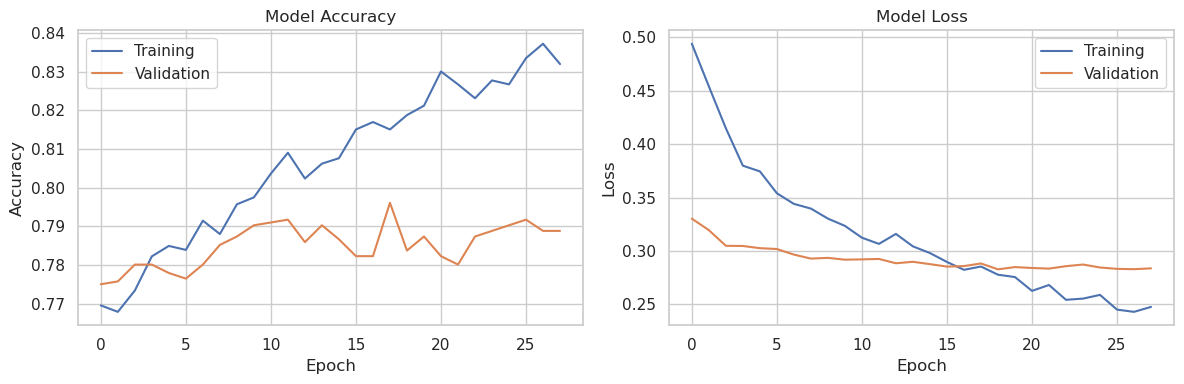

In [36]:
plot_history_subplot(history)

In [37]:
history_finetune = model_manager.fine_tune(
    train_gen,
    val_gen,
    iteration=2,
    num_layers_to_unfreeze=50,
    epochs=30,
    class_weights=class_weights,
)

INFO:__main__:Loaded best model from iteration 2


Epoch 1/30
241/244 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8231 - loss: 0.2754
Epoch 1: val_accuracy improved from -inf to 0.79390, saving model to saved_models/best_model_iter_2_ft.keras
244/244 ━━━━━━━━━━━━━━━━━━━━ 32s 54ms/step - accuracy: 0.8231 - loss: 0.2754 - val_accuracy: 0.7939 - val_loss: 0.2881 - learning_rate: 1.0000e-05
Epoch 2/30
243/244 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8212 - loss: 0.2777
Epoch 2: val_accuracy did not improve from 0.79390
244/244 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.8212 - loss: 0.2777 - val_accuracy: 0.7910 - val_loss: 0.2862 - learning_rate: 1.0000e-05
Epoch 3/30


2024-11-07 18:23:00.954243: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:572: Filling up shuffle buffer (this may take a while): 235 of 7807


  1/244 ━━━━━━━━━━━━━━━━━━━━ 42:07 10s/step - accuracy: 0.8125 - loss: 0.2688

2024-11-07 18:23:01.193997: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


242/244 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8220 - loss: 0.2710
Epoch 3: val_accuracy did not improve from 0.79390
244/244 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - accuracy: 0.8220 - loss: 0.2709 - val_accuracy: 0.7939 - val_loss: 0.2856 - learning_rate: 1.0000e-05
Epoch 4/30
242/244 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8164 - loss: 0.2860
Epoch 4: val_accuracy did not improve from 0.79390
244/244 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.8164 - loss: 0.2859 - val_accuracy: 0.7925 - val_loss: 0.2858 - learning_rate: 1.0000e-05
Epoch 5/30
243/244 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8194 - loss: 0.2688
Epoch 5: val_accuracy improved from 0.79390 to 0.79536, saving model to saved_models/best_model_iter_2_ft.keras
244/244 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - accuracy: 0.8194 - loss: 0.2688 - val_accuracy: 0.7954 - val_loss: 0.2864 - learning_rate: 1.0000e-05
Epoch 6/30


2024-11-07 18:23:39.548962: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:572: Filling up shuffle buffer (this may take a while): 219 of 7807


  1/244 ━━━━━━━━━━━━━━━━━━━━ 43:55 11s/step - accuracy: 0.7812 - loss: 0.3411

2024-11-07 18:23:40.263689: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


243/244 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8223 - loss: 0.2834
Epoch 6: val_accuracy did not improve from 0.79536
244/244 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - accuracy: 0.8223 - loss: 0.2834 - val_accuracy: 0.7896 - val_loss: 0.2859 - learning_rate: 1.0000e-05
Epoch 7/30
242/244 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8291 - loss: 0.2624
Epoch 7: val_accuracy did not improve from 0.79536
244/244 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.8291 - loss: 0.2624 - val_accuracy: 0.7888 - val_loss: 0.2857 - learning_rate: 1.0000e-05
Epoch 8/30
241/244 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8229 - loss: 0.2807
Epoch 8: val_accuracy did not improve from 0.79536

Epoch 8: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
244/244 ━━━━━━━━━━━━━━━━━━━━ 15s 36ms/step - accuracy: 0.8229 - loss: 0.2806 - val_accuracy: 0.7903 - val_loss: 0.2859 - learning_rate: 1.0000e-05
Epoch 9/30
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8260 - loss:

2024-11-07 18:25:23.688950: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:572: Filling up shuffle buffer (this may take a while): 242 of 7807
2024-11-07 18:25:23.741093: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8288 - loss: 0.2601
Epoch 14: val_accuracy did not improve from 0.79536
244/244 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - accuracy: 0.8288 - loss: 0.2601 - val_accuracy: 0.7888 - val_loss: 0.2849 - learning_rate: 5.0000e-06
Epoch 15/30
243/244 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8163 - loss: 0.2796
Epoch 15: val_accuracy did not improve from 0.79536
244/244 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.8164 - loss: 0.2796 - val_accuracy: 0.7917 - val_loss: 0.2849 - learning_rate: 5.0000e-06
Epoch 15: early stopping
Restoring model weights from the end of the best epoch: 5.


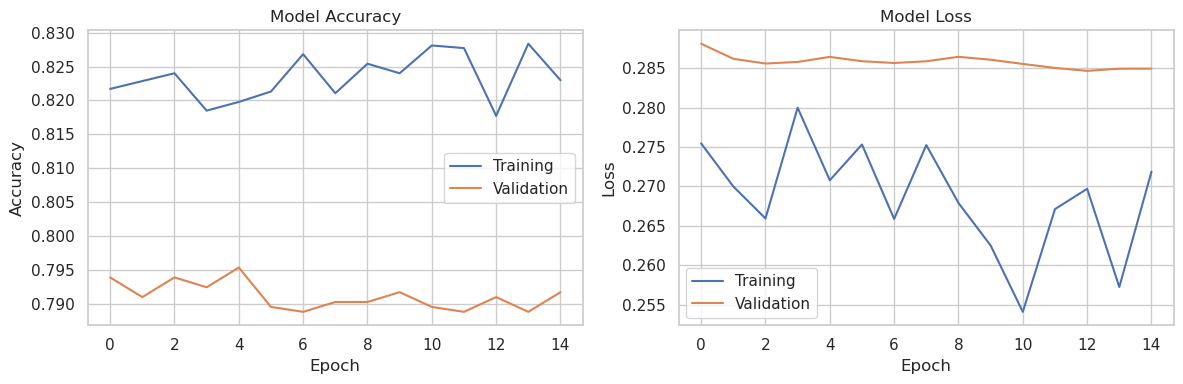

In [38]:
plot_history_subplot(history_finetune)

2024-11-07 18:25:48.353576: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


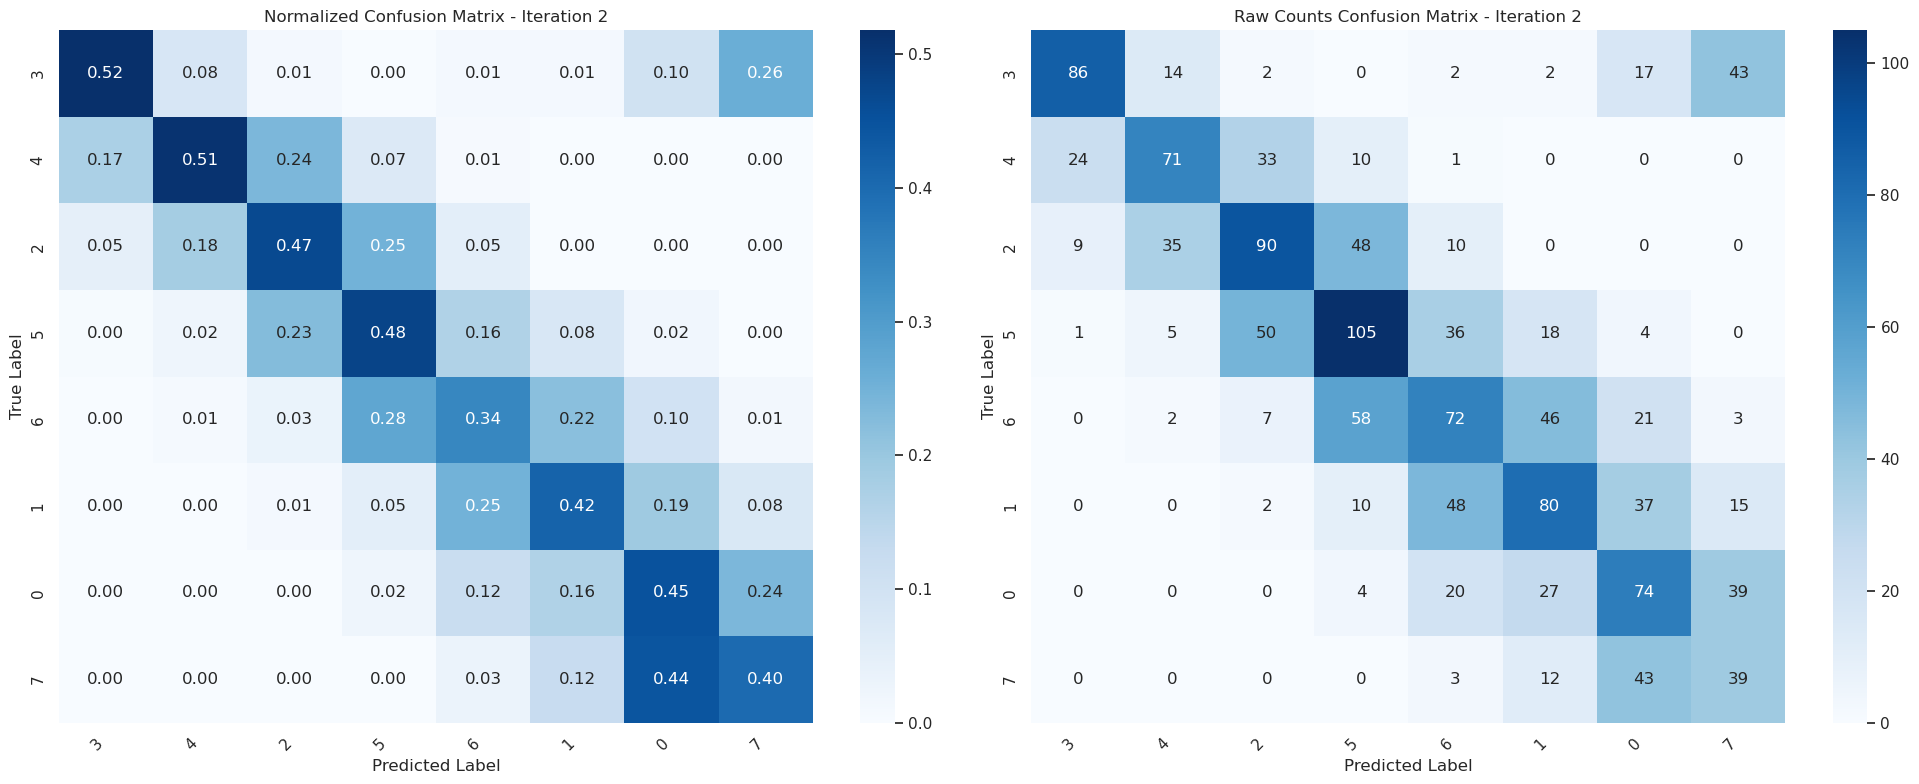

In [39]:
evaluation_results = evaluator.evaluate_iteration(
    iteration=2, test_ds=test_gen, class_names=all_classes
)

In [44]:
evaluator.print_classification_report(iteration=2)


Classification Report - Iteration 2
------------------------------------------------------------
3:::::::::::::: Precision: 0.717  Recall: 0.518  F1-score: 0.601
4:::::::::::::: Precision: 0.559  Recall: 0.511  F1-score: 0.534
2:::::::::::::: Precision: 0.489  Recall: 0.469  F1-score: 0.479
5:::::::::::::: Precision: 0.447  Recall: 0.479  F1-score: 0.463
6:::::::::::::: Precision: 0.375  Recall: 0.344  F1-score: 0.359
1:::::::::::::: Precision: 0.432  Recall: 0.417  F1-score: 0.424
0:::::::::::::: Precision: 0.378  Recall: 0.451  F1-score: 0.411
7:::::::::::::: Precision: 0.281  Recall: 0.402  F1-score: 0.331
------------------------------------------------------------
Accuracy: 0.448
